In [179]:
import requests
from datetime import datetime, timedelta
import json
import pandas as pd

url = 'https://api.binance.com/api/v3/klines'
symbol = 'BTCUSDT'
interval = '1d'
period = datetime.now() - timedelta(450)

data_start = int(period.timestamp()*1000)
date_end = int(datetime.now().timestamp()*1000)

parametres = {
    'symbol' : symbol,
    'interval' : interval,
    'startTime' : data_start,
    'endTime' : date_end
}

res = json.loads(requests.get(url,params = parametres).text)
df= pd.DataFrame(res)
df.columns = ['datetime','open','high','low','close','volume','close_time','qav','num_trades','taker_base_vol','taker_quote_vol','ignore']
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')

df.head()

,datetime,open,high,low,close,volume,close_time,qav,num_trades,taker_base_vol,taker_quote_vol,ignore
0,2022-07-04,19315.83000000,20354.01000000,19055.31000000,20236.71000000,74814.04601000,1656979199999,1470987695.52158190,1282843,38543.72441000,758241531.98802060,0
1,2022-07-05,20236.71000000,20750.00000000,19304.40000000,20175.83000000,96041.13756000,1657065599999,1919950110.16743050,1612273,48358.47507000,967109793.38447560,0
2,2022-07-06,20175.84000000,20675.22000000,19761.25000000,20564.51000000,82439.58080000,1657151999999,1665481948.00963180,1472221,41580.73433000,840150579.64268600,0
3,2022-07-07,20564.51000000,21838.10000000,20251.68000000,21624.98000000,85014.58261000,1657238399999,1783224085.72367990,1653722,42731.53720000,896703207.21045650,0
4,2022-07-08,21624.99000000,22527.37000000,21189.26000000,21594.75000000,403081.57349000,1657324799999,8781330156.61243140,4358216,201798.10144000,4396546053.03190870,0


In [180]:
df.drop(['close_time','qav','taker_base_vol','taker_quote_vol','ignore','num_trades'],axis=1,inplace=True)#Just dropping columns here!
df.head()

,datetime,open,high,low,close,volume
0,2022-07-04,19315.83000000,20354.01000000,19055.31000000,20236.71000000,74814.04601000
1,2022-07-05,20236.71000000,20750.00000000,19304.40000000,20175.83000000,96041.13756000
2,2022-07-06,20175.84000000,20675.22000000,19761.25000000,20564.51000000,82439.58080000
3,2022-07-07,20564.51000000,21838.10000000,20251.68000000,21624.98000000,85014.58261000
4,2022-07-08,21624.99000000,22527.37000000,21189.26000000,21594.75000000,403081.57349000


In [181]:
df.tail()

,datetime,open,high,low,close,volume
445,2023-09-22,26568.08000000,26743.38000000,26468.77000000,26580.14000000,18198.22920000
446,2023-09-23,26580.14000000,26632.81000000,26509.00000000,26575.96000000,9440.70260000
447,2023-09-24,26575.97000000,26738.54000000,26122.08000000,26248.38000000,15706.65771000
448,2023-09-25,26248.39000000,26446.15000000,25990.46000000,26304.81000000,26266.20390000
449,2023-09-26,26304.80000000,26397.46000000,26234.37000000,26279.32000000,4181.06341000


In [182]:
df.isnull().any()#We don't have any NaN values luckily

datetime    False
open        False
high        False
low         False
close       False
volume      False
dtype: bool

In [183]:
df.shape #We can see that we have 1696 observations for bitcoin here 

(450, 6)

In [184]:
df['datetime'] = pd.to_datetime(df['datetime'], unit='ms')
df = df.set_index('datetime')
df.head()


,open,high,low,close,volume
datetime,,,,,
2022-07-04,19315.83000000,20354.01000000,19055.31000000,20236.71000000,74814.04601000
2022-07-05,20236.71000000,20750.00000000,19304.40000000,20175.83000000,96041.13756000
2022-07-06,20175.84000000,20675.22000000,19761.25000000,20564.51000000,82439.58080000
2022-07-07,20564.51000000,21838.10000000,20251.68000000,21624.98000000,85014.58261000
2022-07-08,21624.99000000,22527.37000000,21189.26000000,21594.75000000,403081.57349000


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 450 entries, 2022-07-04 to 2023-09-26
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   open    450 non-null    object
 1   high    450 non-null    object
 2   low     450 non-null    object
 3   close   450 non-null    object
 4   volume  450 non-null    object
dtypes: object(5)
memory usage: 21.1+ KB


In [186]:
df['open'] = df['open'].astype(float)
df['high'] = df['high'].astype(float)
df['low'] = df['low'].astype(float)
df['close'] = df['close'].astype(float)


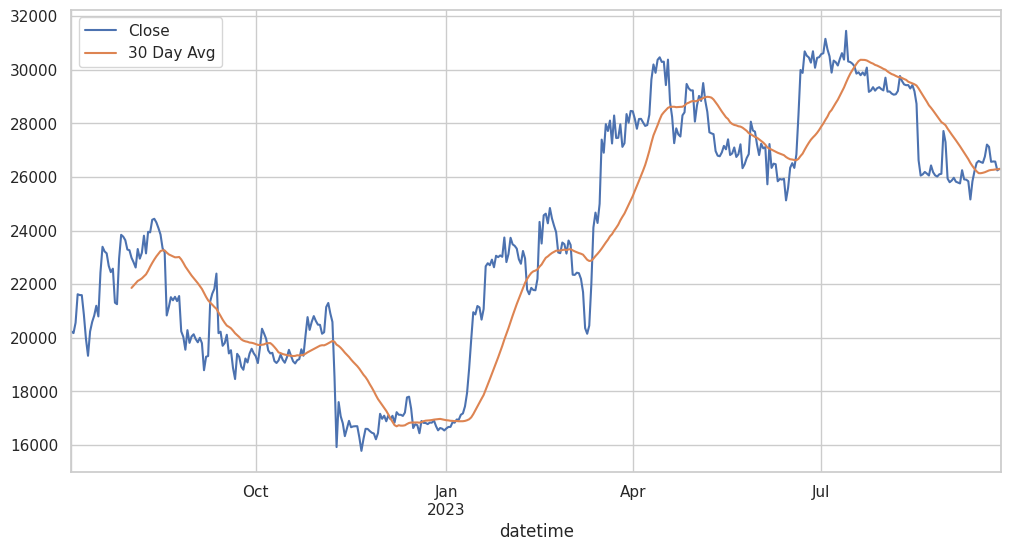

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set()
sns.set_style('whitegrid')

df['close'].plot(figsize=(12,6),label='Close')
df['close'].rolling(window=30).mean().plot(label='30 Day Avg')# Plotting the 

plt.legend()

In [188]:
df['ohlc_average'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4

In [189]:
X = df[:int(len(df)-1)]
y = df['close']
y= y[:int(len(df)-1)]

In [190]:
# The model
from sklearn.ensemble import RandomForestRegressor
reg=RandomForestRegressor(n_estimators=200,random_state=101)

In [191]:
# Split the Dataset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [192]:
#Train the model
reg.fit(X_train,y_train)


RandomForestRegressor(n_estimators=200, random_state=101)

In [193]:
#Test the model
accuracy=reg.score(X_test,y_test)
accuracy=accuracy*100
accuracy = float("{0:.4f}".format(accuracy))
print('Accuracy is:',accuracy,'%')#This percentage shows how much our regression fits our data

Accuracy is: 99.9691 %


In [194]:
#Make the predictions
new_data = df.tail(1)
prediction = reg.predict(new_data)
print ( "The predcition is : ",prediction)
print ( "The last price was : ",df[['close']].tail(1).values[0][0])



The predcition is :  [26253.11155]
The last price was :  26279.32
